In [1]:
import sys
sys.path.insert(1, "..")

from utils import llm_api
from exposure.tasks import key_values
import numpy as np
import random
import string
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from exposure.tasks import letters

Config the hyper-parameters for exposure discovery

In [2]:
SAMPLES = 100
LENGTHS = [200, 500, 1000, 2000]
MODEL = "gpt-3.5-turbo"

Run the experiment. Create a sentence with a set of tokens (alphabetic letters), then ask about the number of each letter.

In [61]:
each = string.ascii_uppercase
pattern = r"\('?(\D)'?: ?(\d+)\)"

df = {
    "letter": [],
    "error": [],
    "position": [],
    "length": []
}

for length in LENGTHS:
    for _ in tqdm(range(SAMPLES), desc=f"length: {length}"):
        prompt = letters.make_random_prompt(length, each)

        response = llm_api.ask(questions=[
            "Count the number of each capital letter in the next text. Output like ('letter': 'count) for all letters present in the text.",
            prompt
        ], model=MODEL)

        
        result = letters.get_letter_counts(response)

        for tu in result:
            letter = tu[0]
            count = tu[1]
            gt = letters.get_gt(prompt, letter)
            error = abs(gt - count)
            df["letter"].append(letter)
            df["error"].append(error)
            df["position"].append(prompt.find(letter))
            df["length"].append(length)
df = pd.DataFrame(df)

length: 2000: 100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Save the results

In [2]:
df_gpt_3 = pd.read_csv("gpt-3.5-turbo.csv")
df_gpt_4 = pd.read_csv("gpt-4o-mini.csv")

### Visualize Exposures

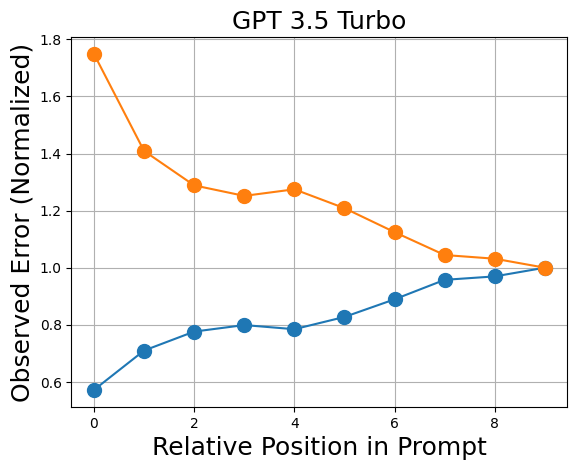

In [23]:
vis_df = df_gpt_3[df_gpt_3["length"] == 1000][["error", "position"]].groupby("position").mean().reset_index()
vis_df = vis_df[vis_df['position'] >= 0]
vis_df["position"] = vis_df["position"] // 200

vis_df = vis_df.groupby("position").mean().reset_index()
vis_df["error"] = vis_df["error"] / vis_df["error"].max()
plt.plot(
    vis_df["position"],
    vis_df["error"],
    marker="o",
    markersize=10
)
plt.plot(
    vis_df["position"],
    np.divide(1, vis_df["error"]),
    marker="o",
    markersize=10
)
plt.grid()
plt.xlabel("Relative Position in Prompt", fontsize=18)
plt.ylabel("Observed Error (Normalized)", fontsize=18)
plt.title("GPT 3.5 Turbo", fontsize=18);
# plt.savefig("../figures/exposure-gpt-3.5.eps", format="eps")

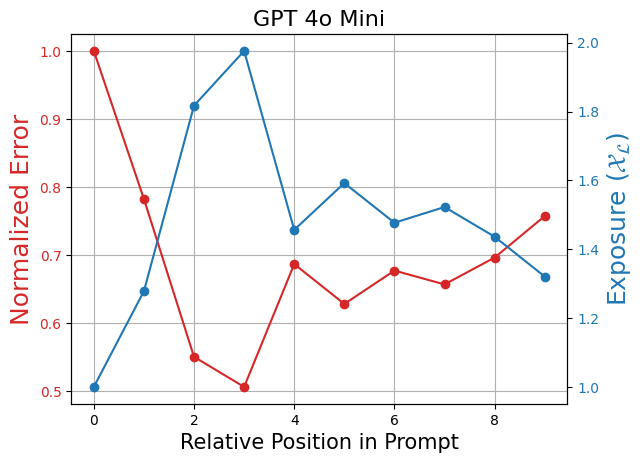

In [42]:
fig, ax1 = plt.subplots()


vis_df = df_gpt_4[df_gpt_4["length"] == 1000][["error", "position"]].groupby("position").mean().reset_index()
vis_df = vis_df[vis_df['position'] >= 0]
vis_df["position"] = vis_df["position"] // 200

vis_df = vis_df.groupby("position").mean().reset_index()
vis_df["error"] = vis_df["error"] / vis_df["error"].max()

plt.title("GPT 4o Mini", fontsize=16)
plt.grid()

# Plot error
ax1.set_xlabel('Relative Position in Prompt', fontsize=15)
ax1.set_ylabel('Normalized Error', fontsize=18, color='tab:red')
ax1.plot(
    vis_df["position"], 
    vis_df["error"], 
    color='tab:red',
    marker="o"
)
    
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create second y-axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Exposure ($\mathcal{X}_{\mathcal{L}}$)', fontsize=18, color='tab:blue')
ax2.plot(
    vis_df["position"], 
    np.divide(1, vis_df["error"]), 
    color='tab:blue',
    marker="o"
)
ax2.tick_params(axis='y', labelcolor='tab:blue')
# plt.savefig("../figures/exposure-gpt-4o.eps", format="eps")